# MSDS 422 Assignment 8: Dogs vs. Cats Redux: Kernel Edition

#### Kay Quiballo | 02/21/2022

## Management/Research Question

The Dogs vs. Cats Redux:  Kernel Edition (Links to an external site.) on Kaggle.com is a foundational CNN problem. This week, you will compete in this competition and submit scores to Kaggle.com.

RECOMMENDATION: the data set here is large, so you might consider conducting exploratory data analysis and building initial models on a smaller subsample prior to applying it to the full dataset.  Eventually, you will need to build your models on the entirety, though.

## Requirements
1. Conduct your analysis using a cross-validation design.
2. Conduct EDA.
3. Build at least three CNN models based on hyperparameter tuning.
4. Evaluate goodness of fit metrics.
5. Build ROC and Precision / Recall graphs.
6. Once you have your best-performing models, classify the test data and submit it to Kaggle. Provide your Kaggle.com user name and screen snapshots of your scores.
7. Discuss your model’s performance.


In [1]:
import os, cv2, random
from tqdm import tqdm
import numpy as np
import pandas as pd
from random import shuffle 

In [2]:
epochs = 10
batch_size = 10

In [3]:
def label_pet_image_one_hot_encoder(img):
    pet = img.split('.')[-3]
    if pet == 'cat': return [1,0]
    elif pet == 'dog': return [0,1]
    
def process_data(data_image_list, DATA_FOLDER, isTrain=True):
    data_df = []
    for img in tqdm(data_image_list):
        path = os.path.join(DATA_FOLDER,img)
        if(isTrain):
            label = label_pet_image_one_hot_encoder(img)
        else:
            label = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (224,224))
        data_df.append([np.array(img),np.array(label)])
    shuffle(data_df)
    return data_df

In [4]:
train = process_data(os.listdir("./train/"), './train/')
#train = process_data(os.listdir("./train_total/"), './train_total/')

100%|██████████| 400/400 [00:02<00:00, 196.29it/s]


In [5]:
test = process_data(os.listdir("./test/"), './test/', False)

100%|██████████| 12500/12500 [00:55<00:00, 225.93it/s]


In [6]:
X = np.array([i[0] for i in train]).reshape(-1,224,224,3)
y = np.array([i[1] for i in train])

In [7]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model
from keras.applications import resnet
#from tensorflow.python.keras.applications.resnet50 import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
import plotly.express as px
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_curve

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.5, random_state=42)
#y_test = np.asarray(test_labels).astype('float32').reshape((-1,1))

Epoch 1/10
20/20 [==============================] - 128s 6s/step - loss: 37.4843 - accuracy: 0.5450 - val_loss: 64953.8555 - val_accuracy: 0.5100
Epoch 2/10
20/20 [==============================] - 113s 6s/step - loss: 4.2048 - accuracy: 0.5300 - val_loss: 4112.2417 - val_accuracy: 0.4650
Epoch 3/10
20/20 [==============================] - 109s 5s/step - loss: 2.2336 - accuracy: 0.5450 - val_loss: 492.4722 - val_accuracy: 0.4600
Epoch 4/10
20/20 [==============================] - 113s 6s/step - loss: 2.2207 - accuracy: 0.5000 - val_loss: 69.2901 - val_accuracy: 0.4500
Epoch 5/10
20/20 [==============================] - 107s 5s/step - loss: 1.3374 - accuracy: 0.5450 - val_loss: 5.4860 - val_accuracy: 0.5400
Epoch 6/10
20/20 [==============================] - 108s 5s/step - loss: 1.4749 - accuracy: 0.5500 - val_loss: 1.7112 - val_accuracy: 0.6000
Epoch 7/10
20/20 [==============================] - 111s 6s/step - loss: 1.6296 - accuracy: 0.5600 - val_loss: 3.0595 - val_accuracy: 0.5750
Ep

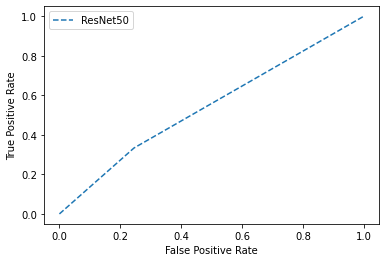

In [9]:
#ResNet50
model1 = Sequential()
model1.add(resnet.ResNet50(include_top=False, pooling='max', weights='imagenet'))
model1.add(Dense(2, activation='softmax'))
model1.layers[0].trainable = True
model1.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
train_model = model1.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_val, y_val))

#=====================================
print('ResNet50: ROC AUC=%.3f' % (roc_auc_score(y_val, model1.predict(X_val))))
fpr, tpr, thresholds = roc_curve(y_val.argmax(axis=1), model1.predict(X_val).argmax(axis=1))
plt.plot(fpr, tpr, linestyle='--', label='ResNet50')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

1/1 [==============================] - 371s 371s/step - loss: 64.1940 - accuracy: 0.4900 - val_loss: 19146303488.0000 - val_accuracy: 0.5100
VGG16: ROC AUC=0.500


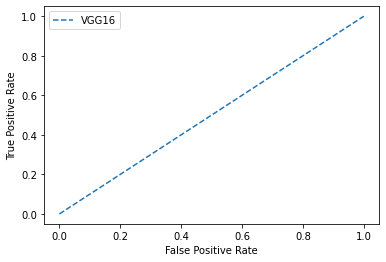

In [16]:
#VGG16
from keras.applications.vgg16 import VGG16
model2 = Sequential()
model2.add(VGG16(include_top=False, pooling='max', weights='imagenet'))
model2.add(Dense(2, activation='softmax'))
model2.layers[0].trainable = True
model2.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
train_model = model2.fit(X_train, y_train, batch_size=200, epochs=1, verbose=1, validation_data=(X_val, y_val))

#=====================================
print('VGG16: ROC AUC=%.3f' % (roc_auc_score(y_val, model2.predict(X_val))))
fpr, tpr, thresholds = roc_curve(y_val.argmax(axis=1), model2.predict(X_val).argmax(axis=1))
plt.plot(fpr, tpr, linestyle='--', label='VGG16')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

1/1 [==============================] - 435s 435s/step - loss: 60.7110 - accuracy: 0.4700 - val_loss: 24880857088.0000 - val_accuracy: 0.4900
VGG19: ROC AUC=0.500


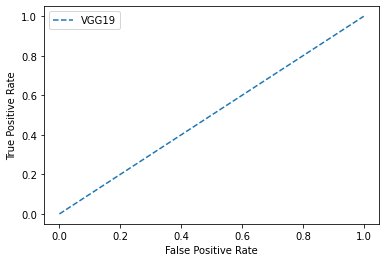

In [18]:
#VGG19
from keras.applications.vgg19 import VGG19
model3 = Sequential()
model3.add(VGG19(include_top=False, pooling='max', weights='imagenet'))
model3.add(Dense(2, activation='softmax'))
model3.layers[0].trainable = True
model3.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
train_model = model3.fit(X_train, y_train, batch_size=200, epochs=1, verbose=1, validation_data=(X_val, y_val))

#=====================================
print('VGG19: ROC AUC=%.3f' % (roc_auc_score(y_val, model3.predict(X_val))))
fpr, tpr, thresholds = roc_curve(y_val.argmax(axis=1), model3.predict(X_val).argmax(axis=1))
plt.plot(fpr, tpr, linestyle='--', label='VGG19')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

1/1 [==============================] - 95s 95s/step - loss: 1.6040 - accuracy: 0.3900 - val_loss: 13.0281 - val_accuracy: 0.4900
InceptionV3: ROC AUC=0.452


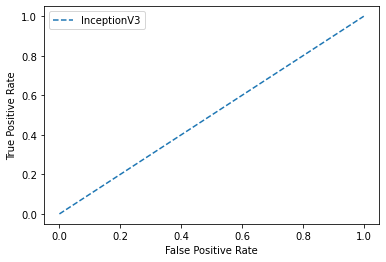

In [19]:
#InceptionV3
from keras.applications.inception_v3 import InceptionV3
model4 = Sequential()
model4.add(InceptionV3(include_top=False, pooling='max', weights='imagenet'))
model4.add(Dense(2, activation='softmax'))
model4.layers[0].trainable = True
model4.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
train_model = model4.fit(X_train, y_train, batch_size=200, epochs=1, verbose=1, validation_data=(X_val, y_val))

#=====================================
print('InceptionV3: ROC AUC=%.3f' % (roc_auc_score(y_val, model4.predict(X_val))))
fpr, tpr, thresholds = roc_curve(y_val.argmax(axis=1), model4.predict(X_val).argmax(axis=1))
plt.plot(fpr, tpr, linestyle='--', label='InceptionV3')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

1/1 [==============================] - 381s 381s/step - loss: 0.7553 - accuracy: 0.5950 - val_loss: 1.2815 - val_accuracy: 0.5050
Xception: ROC AUC=0.449


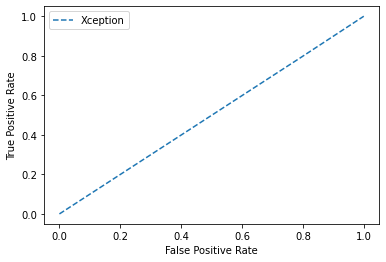

In [20]:
#Xception
from keras.applications.xception import Xception
model5 = Sequential()
model5.add(Xception(include_top=False, pooling='max', weights='imagenet'))
model5.add(Dense(2, activation='softmax'))
model5.layers[0].trainable = True
model5.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
train_model = model5.fit(X_train, y_train, batch_size=200, epochs=1, verbose=1, validation_data=(X_val, y_val))

#=====================================
print('Xception: ROC AUC=%.3f' % (roc_auc_score(y_val, model5.predict(X_val))))
fpr, tpr, thresholds = roc_curve(y_val.argmax(axis=1), model5.predict(X_val).argmax(axis=1))
plt.plot(fpr, tpr, linestyle='--', label='Xception')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [21]:
pred_list = []
img_list = []
for img in tqdm(test):
    img_data = img[0]
    img_idx = img[1]
    data = img_data.reshape(-1,224,224,3)
    predicted = model1.predict([data])[0]
    img_list.append(img_idx)
    pred_list.append(predicted[1])
    
submission = pd.DataFrame({'id':img_list , 'label':pred_list})
submission.head()
submission.to_csv("submission1.csv", index=False)    

  0%|          | 0/12500 [00:00<?, ?it/s]

Consider rewriting this model with the Functional API.


100%|██████████| 12500/12500 [40:45<00:00,  5.11it/s] 


In [23]:
pred_list = []
img_list = []
for img in tqdm(test):
    img_data = img[0]
    img_idx = img[1]
    data = img_data.reshape(-1,224,224,3)
    predicted = model2.predict([data])[0]
    img_list.append(img_idx)
    pred_list.append(predicted[1])
    
submission = pd.DataFrame({'id':img_list , 'label':pred_list})
submission.head()
submission.to_csv("submission2.csv", index=False)    

  0%|          | 0/12500 [00:00<?, ?it/s]

Consider rewriting this model with the Functional API.


100%|██████████| 12500/12500 [1:05:16<00:00,  3.19it/s]


In [24]:
pred_list = []
img_list = []
for img in tqdm(test):
    img_data = img[0]
    img_idx = img[1]
    data = img_data.reshape(-1,224,224,3)
    predicted = model3.predict([data])[0]
    img_list.append(img_idx)
    pred_list.append(predicted[1])
    
submission = pd.DataFrame({'id':img_list , 'label':pred_list})
submission.head()
submission.to_csv("submission3.csv", index=False)    

  0%|          | 0/12500 [00:00<?, ?it/s]

Consider rewriting this model with the Functional API.


100%|██████████| 12500/12500 [1:19:14<00:00,  2.63it/s]


In [25]:
pred_list = []
img_list = []
for img in tqdm(test):
    img_data = img[0]
    img_idx = img[1]
    data = img_data.reshape(-1,224,224,3)
    predicted = model4.predict([data])[0]
    img_list.append(img_idx)
    pred_list.append(predicted[1])
    
submission = pd.DataFrame({'id':img_list , 'label':pred_list})
submission.head()
submission.to_csv("submission4.csv", index=False)    

  0%|          | 0/12500 [00:00<?, ?it/s]

Consider rewriting this model with the Functional API.


100%|██████████| 12500/12500 [27:51<00:00,  7.48it/s]


In [26]:
pred_list = []
img_list = []
for img in tqdm(test):
    img_data = img[0]
    img_idx = img[1]
    data = img_data.reshape(-1,224,224,3)
    predicted = model5.predict([data])[0]
    img_list.append(img_idx)
    pred_list.append(predicted[1])
    
submission = pd.DataFrame({'id':img_list , 'label':pred_list})
submission.head()
submission.to_csv("submission5.csv", index=False)    

  0%|          | 0/12500 [00:00<?, ?it/s]

Consider rewriting this model with the Functional API.


100%|██████████| 12500/12500 [37:04<00:00,  5.62it/s]


### Results
Model 1 (ResNet50 : Score=1.49286, accuracy: 0.6300) <br>
Model 2 (VGG16 : Score=17.26978, accuracy: 0.4900) <br>
Model 3 (VGG19 : Score=17.26938, accuracy: 0.4700) <br>
Model 4 (InceptionV3 : Score=11.90260, accuracy: 0.3900) <br>
Model 5 (Xception : Score=1.23464, accuracy: 0.5950) <br>

These models had accuracy ranging from 39% (M4) to 63% (M1). Relatively, when predicting whether an image is a dog or a cat, only M1 and M5 have accuracies better than guessing (50%). Two areas that need improvement to the analysis are the amount of time it took to run each model as well as the training dataset. Only 100 cat images and 100 dog images were used for training when there were a total of 25,000 that could have been used, which in turn would have improved accuracy. Additionally, during the hyperparameter tuning, increasing the epochs or changing the batch sizes also contributed to possibly better accuracy with the tradeoff of runtime. With hyperparameters being tuned to the shortest runtime and small training set, each model took hours to run, and a randomized cv search would have taken even longer. One last thing that could use investigation is model weights. Many other analysts have used weight files but I was only able to run a default function in the weight parameter. In conclusion, making a model with great accuracy would require more time to process data and discover different neural networks. It may be worth looking into methods that increase accuracy without sacrificing such long runtimes. With the models produced, they may be slightly better than guessing, but not by much (~10-15%).